In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

In [23]:
labels_df = pd.read_csv("labels.csv")
counts_df = pd.read_csv("processed_counts.csv")

In [24]:
labels_df = pd.read_csv("labels.csv")
counts_df = pd.read_csv("processed_counts.csv")
label_barcode_col_name = labels_df.columns[0]
label_value_col_name = labels_df.columns[1]
counts_barcode_col_name = counts_df.columns[0]
gene_column_names = counts_df.columns[1:]
merged_df = pd.merge(
    left=counts_df,
    right=labels_df[[label_barcode_col_name, label_value_col_name]],
    left_on=counts_barcode_col_name,
    right_on=label_barcode_col_name,
    how='inner'
)
print(f"merged_df shape after merge: {merged_df.shape}")
shuffled_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
X = shuffled_df[gene_column_names]
y = shuffled_df[label_value_col_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False,
    random_state=42  
)
print("--- Data Shapes After Splitting ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

merged_df shape after merge: (700, 768)
--- Data Shapes After Splitting ---
X_train shape: (560, 765)
y_train shape: (560,)
X_test shape: (140, 765)
y_test shape: (140,)


In [25]:
shuffled_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
X = shuffled_df[gene_column_names]
y = shuffled_df[label_value_col_name]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False,
    random_state=42  
)
print("--- Data Shapes After Splitting ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

--- Data Shapes After Splitting ---
X_train shape: (560, 765)
y_train shape: (560,)
X_test shape: (140, 765)
y_test shape: (140,)


In [26]:
if 'X_train' not in globals() or 'X_test' not in globals():
     raise NameError("X_train and/or X_test from Part 1 are not defined.")

print(f"Using X_train shape: {X_train.shape}, X_test shape: {X_test.shape} for autoencoder tuning.")

print("Combining and scaling data for the new autoencoder...")
if isinstance(X_train, pd.DataFrame) and isinstance(X_test, pd.DataFrame):
    X_all_part1_original = pd.concat([X_train, X_test], axis=0)
    X_all_part1_np = X_all_part1_original.values
elif isinstance(X_train, np.ndarray) and isinstance(X_test, np.ndarray):
    X_all_part1_original = np.concatenate([X_train, X_test], axis=0)
    X_all_part1_np = X_all_part1_original
else:
    raise TypeError("X_train and X_test (Part 1) must be both Pandas DataFrames or NumPy arrays.")

scaler_part1_revised = MinMaxScaler()
X_all_scaled_part1_revised = scaler_part1_revised.fit_transform(X_all_part1_np)
print(f"X_all_scaled_part1_revised shape: {X_all_scaled_part1_revised.shape}")

input_dim_revised = X_all_scaled_part1_revised.shape[1]

Using X_train shape: (560, 765), X_test shape: (140, 765) for autoencoder tuning.
Combining and scaling data for the new autoencoder...
X_all_scaled_part1_revised shape: (700, 765)


In [27]:
def create_revised_autoencoder(input_dim, latent_dim=32,
                               encoder_layers_config=[(128, 'relu'), (64, 'relu')],
                               decoder_layers_config=[(64, 'relu'), (128, 'relu')], 
                               latent_activation='relu',
                               output_activation='sigmoid',
                               l1_factor=0.0, 
                               l2_factor=0.0, 
                               dropout_rate=0.0): 

    # Encoder
    encoder_input = keras.Input(shape=(input_dim,), name="encoder_input")
    x = encoder_input
    for i, (units, activation) in enumerate(encoder_layers_config):
        x = layers.Dense(units, activation=activation,
                         kernel_regularizer=regularizers.l2(l2_factor) if l2_factor > 0 else None,
                         name=f"encoder_dense_{i+1}")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name=f"encoder_dropout_{i+1}")(x)

    # Latent space
    activity_reg = regularizers.l1(l1_factor) if l1_factor > 0 else None
    encoder_output = layers.Dense(latent_dim, activation=latent_activation,
                                  activity_regularizer=activity_reg,
                                  kernel_regularizer=regularizers.l2(l2_factor) if l2_factor > 0 else None,
                                  name="encoder_output_latent_space")(x)
    revised_encoder = Model(encoder_input, encoder_output, name="revised_encoder")

    # Decoder
    decoder_input_latent_space = keras.Input(shape=(latent_dim,), name="decoder_input_latent_space")
    x = decoder_input_latent_space
    if not decoder_layers_config:
        decoder_layers_config = [(units, activation) for units, activation in reversed(encoder_layers_config)]

    for i, (units, activation) in enumerate(decoder_layers_config):
        x = layers.Dense(units, activation=activation,
                         kernel_regularizer=regularizers.l2(l2_factor) if l2_factor > 0 else None,
                         name=f"decoder_dense_{i+1}")(x)
        if dropout_rate > 0: # Apply dropout symmetrically if used in encoder
            x = layers.Dropout(dropout_rate, name=f"decoder_dropout_{i+1}")(x)
            
    decoder_output_reconstruction = layers.Dense(input_dim, activation=output_activation,
                                                 name="decoder_output_reconstruction")(x)
    revised_decoder = Model(decoder_input_latent_space, decoder_output_reconstruction, name="revised_decoder")

    autoencoder_main_input = keras.Input(shape=(input_dim,), name="autoencoder_main_input")
    encoded_representation = revised_encoder(autoencoder_main_input)
    reconstructed_output = revised_decoder(encoded_representation)
    revised_autoencoder = Model(autoencoder_main_input, reconstructed_output, name="revised_autoencoder")

    revised_autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    
    print("--- Revised Encoder Summary ---")
    revised_encoder.summary()
    print("\n--- Revised Autoencoder Summary ---")
    revised_autoencoder.summary()
    
    return revised_autoencoder, revised_encoder

In [28]:
config_name = "AE_Latent64_NoL1_L2_Dropout" # Experiment name

latent_dim_exp = 64
encoder_layers_exp = [(256, 'relu'), (128, 'relu')]
decoder_layers_exp = [(128, 'relu'), (256, 'relu')] # Mirrored
latent_activation_exp = 'linear' 
l1_factor_exp = 0.0 
l2_factor_exp = 1e-5 # Add some L2 regularization to dense layers
dropout_rate_exp = 0.2 # Add dropout

revised_autoencoder_model, revised_encoder_model = create_revised_autoencoder(
    input_dim=input_dim_revised,
    latent_dim=latent_dim_exp,
    encoder_layers_config=encoder_layers_exp,
    decoder_layers_config=decoder_layers_exp,
    latent_activation=latent_activation_exp,
    l1_factor=l1_factor_exp,
    l2_factor=l2_factor_exp,
    dropout_rate=dropout_rate_exp
)

--- Revised Encoder Summary ---


Model: "revised_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 765)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 256)            │       196,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_2 (Dropout)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output_latent_space     │ (None, 64)             │         8,256 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,248 (926.75 KB)

 Trainable params: 237,248 (926.75 KB)

 Non-trainable params: 0 (0.00 B)


--- Revised Autoencoder Summary ---


Model: "revised_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_main_input          │ (None, 765)            │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ revised_encoder (Functional)    │ (None, 64)             │       237,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ revised_decoder (Functional)    │ (None, 765)            │       237,949 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,197 (1.81 MB)

 Trainable params: 475,197 (1.81 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Revised Autoencoder: AE_Latent64_NoL1_L2_Dropout ---
Epoch 1/200


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1621 - val_loss: 0.0386
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0376 - val_loss: 0.0381
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0373 - val_loss: 0.0375
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0364 - val_loss: 0.0368
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358 - val_loss: 0.0363
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0353 - val_loss: 0.0358
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0352 - val_loss: 0.0353
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0347 - val_loss: 0.0349
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0343 - val_loss: 0.0346
Epoch 10/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0336 - val_loss: 0.0343
Epoch 11/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0337 - val_loss: 0.0340
Epoch 12/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0332 - val_l

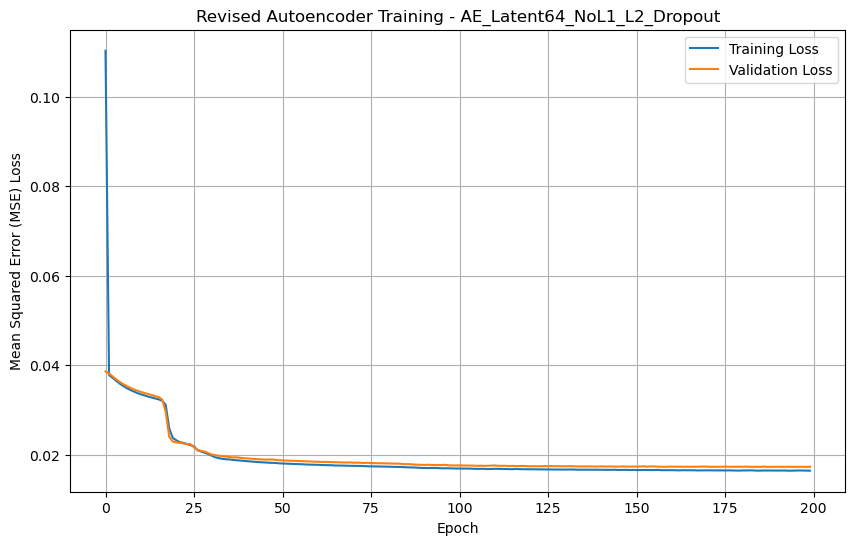

In [29]:
print(f"\n--- Training Revised Autoencoder: {config_name} ---")
ae_early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

history_revised_ae = revised_autoencoder_model.fit(
    X_all_scaled_part1_revised, X_all_scaled_part1_revised,
    epochs=200,
    batch_size=32,
    shuffle=True,
    validation_split=0.15,
    callbacks=[ae_early_stopping],
    verbose=1
)

print("\n--- Plotting Training and Validation Loss for Revised Autoencoder ---")
plt.figure(figsize=(10, 6))
plt.plot(history_revised_ae.history['loss'], label='Training Loss')
plt.plot(history_revised_ae.history['val_loss'], label='Validation Loss')
plt.title(f'Revised Autoencoder Training - {config_name}')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE) Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
final_reconstruction_loss = revised_autoencoder_model.evaluate(X_all_scaled_part1_revised, X_all_scaled_part1_revised, verbose=0)
print(f"Final reconstruction MSE on all data for {config_name}: {final_reconstruction_loss:.6f}")

Final reconstruction MSE on all data for AE_Latent64_NoL1_L2_Dropout: 0.016239


In [36]:
encoder_filename = f"{config_name}.keras"
scaler_filename = f"{config_name}.joblib"
revised_encoder_model.save(encoder_filename)
joblib.dump(scaler_part1_revised, scaler_filename)

['AE_Latent64_NoL1_L2_Dropout.joblib']

Found y_train and y_test. Concatenating them for y_all_labels_series_part1.
Successfully created y_all_labels_series_part1 with 700 labels.
Generating latent space representations using encoder: AE_Latent64_NoL1_L2_Dropout...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Shape of latent space data: (700, 64)
Applying PCA to the 64D latent space to get 2D representation...
Shape of PCA output (from latent space): (700, 2)
Generating plot...


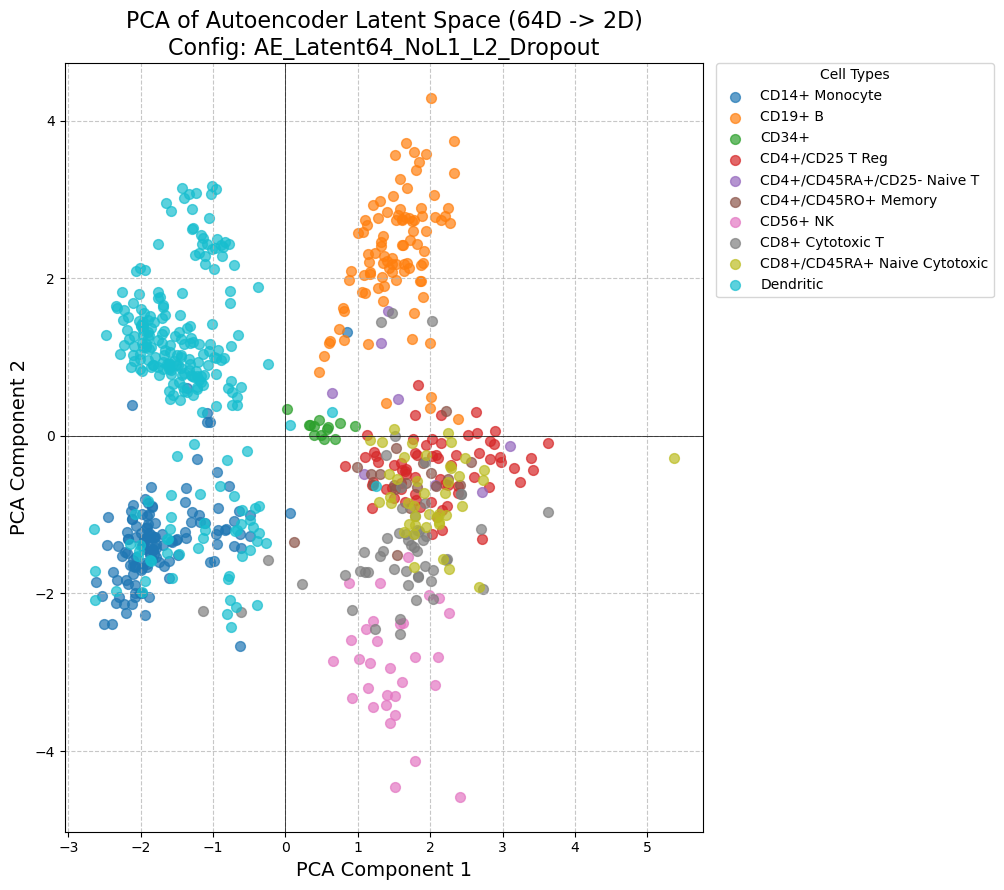

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm 
from sklearn.decomposition import PCA

if 'revised_encoder_model' not in globals():
    raise NameError("The 'revised_encoder_model' is not defined.")
if 'X_all_scaled_part1_revised' not in globals():
    raise NameError("'X_all_scaled_part1_revised' is not defined.")

if 'y_train' in globals() and 'y_test' in globals():
    print("Found y_train and y_test.")
    if isinstance(y_train, pd.Series) and isinstance(y_test, pd.Series):
        y_all_labels_part1_combined = pd.concat([y_train, y_test], ignore_index=True)
    elif isinstance(y_train, np.ndarray) and isinstance(y_test, np.ndarray):
        y_all_labels_part1_combined = np.concatenate([y_train, y_test])
    else:
        raise TypeError("y_train and y_test must be both Pandas Series or NumPy arrays")
    
    y_all_labels_series_part1 = pd.Series(y_all_labels_part1_combined)
    
    if len(y_all_labels_series_part1) != X_all_scaled_part1_revised.shape[0]:
        raise ValueError(f"Length mismatch: y_all_labels_series_part1 ({len(y_all_labels_series_part1)}) "
                         f"and X_all_scaled_part1_revised ({X_all_scaled_part1_revised.shape[0]}). "
                         "Ensure y_train/y_test correspond to the X_train/X_test used to create X_all_scaled_part1_revised.")
    print(f"Successfully created y_all_labels_series_part1 with {len(y_all_labels_series_part1)} labels.")

elif 'y_all_labels_series_part1' not in globals():
    raise NameError("'y_all_labels_series_part1' (true cell type labels) is not defined, "
                    "and y_train/y_test are not available in the global scope to construct it.")

if 'config_name' not in globals():
    config_name = "AE_Latent64_NoL1_L2_Dropout" 
    print(f"Warning: 'config_name' not set, using default: {config_name}")


print(f"Generating latent space representations using encoder: {config_name}...")
latent_space_data_revised = revised_encoder_model.predict(X_all_scaled_part1_revised)
print(f"Shape of latent space data: {latent_space_data_revised.shape}") 

print(f"Applying PCA to the {latent_space_data_revised.shape[1]}D latent space to get 2D representation...")
pca_on_latent_revised = PCA(n_components=2, random_state=42)
X_pca_latent_revised = pca_on_latent_revised.fit_transform(latent_space_data_revised)
print(f"Shape of PCA output (from latent space): {X_pca_latent_revised.shape}")

def plot_2d_representation_custom(data_2d, labels_series, title_str):
    """Custom plotting function for 2D representations."""
    plt.figure(figsize=(12, 9))
    
    unique_labels = sorted(labels_series.unique())
    
    if len(unique_labels) <= 10:
        cmap_func = cm.get_cmap('tab10')
    elif len(unique_labels) <= 20:
        cmap_func = cm.get_cmap('tab20')
    else:
        # Fallback
        cmap_func = cm.get_cmap('viridis', len(unique_labels))

    for i, label in enumerate(unique_labels):
        idx = (labels_series == label).values 
        
        current_data = data_2d[idx] 
        

        if hasattr(cmap_func, 'colors'):
            color_val = cmap_func.colors[i % len(cmap_func.colors)]
        else: 
            color_val = cmap_func(i / (len(unique_labels)-1)) if len(unique_labels) > 1 else cmap_func(0.5)
            
        plt.scatter(current_data[:, 0], current_data[:, 1],
                    color=color_val,
                    label=str(label), alpha=0.7, s=50)
    
    plt.title(title_str, fontsize=16)
    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    # Place legend outside the plot
    plt.legend(title="Cell Types", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

print("Generating plot...")
plot_title = f"PCA of Autoencoder Latent Space ({latent_space_data_revised.shape[1]}D -> 2D)\nConfig: {config_name}"
plot_2d_representation_custom(X_pca_latent_revised, y_all_labels_series_part1, plot_title)

